In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import LogStretch, MinMaxInterval, ImageNormalize
from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import scipy.stats as stats
from scipy.optimize import curve_fit


data_file = 'ic2r02050_drz.fits'

In [4]:
def read_fits_data(data_file):
    """Reads in data from data_file, expects a fits file with the information 
    stored in [1], returns the data, the nanmean of the data, the header, the 
    wcs of the data. Addtionaly removes nanvalues (replaces them with zeros)
    
    returns data, nanmean, wcs, header"""
    with fits.open(data_file) as hdulist:
        data = hdulist[1].data
        # subtract mean, and remove nans
        nanmean = np.nanmean(data)
        data = data
        data[np.isnan(data)] = np.zeros(np.shape(data))[np.isnan(data)]
        header =  hdulist[1].header
        wcs = WCS(header)

    return data, nanmean, wcs, header



def make_sky_image(data, wcs):
    # get some params
    stretch = LogStretch()
    interval = MinMaxInterval()
    norm = ImageNormalize(data, interval=interval, stretch=stretch, vmin=0)

    # make figure 
    fig = plt.figure(figsize=(12, 8), dpi=350)
    plt.subplot(projection=wcs)
    plt.imshow(data + nanmean, origin='lower', cmap='gray', norm=norm, ) # aspect='auto')


    plt.colorbar(label='Intensity (Log Scale)')


    #plt.xlabel('X-axis (Pixels)',size=15)
    #plt.ylabel('Y-axis (pixels)', size=15)
    plt.title('FITS Image with Log Stretch Normalization', size=15)
    #plt.savefig('hail_sagan.pdf')


def find_sources(data, nanmean, snr_threshold, sigma=5):
    mean, median, std = sigma_clipped_stats(data, sigma=sigma)

    daofinder = DAOStarFinder(
        fwhm=3,                 # FWHM of the stars in your image (adjust as needed)
        threshold=(6* std) + nanmean,      # Adjust the threshold as needed
        exclude_border=True       # Exclude sources near the image border
    )

    sources = daofinder.find_stars(data)

    # Get x and y centroids of the detected stars
    x_centroids = sources['xcentroid']
    y_centroids = sources['ycentroid']

    return x_centroids, y_centroids



# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev, c):
    return (amplitude * np.exp(-((x - mean)**2 / (2 * stddev ** 2)))) +c



def histogram_plots(x_centroids, y_centroids,):

    # x axis plot
    # Compute the histogram using np.histogram
    fig = plt.figure(figsize=(8, 6), dpi=100)
    hist, bins = np.histogram(x_centroids, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create the histogram 
    # fit gaussian 
    p0 = [np.max(hist), np.mean(bin_centers), np.std(hist), np.min(hist)]
    params, covariance = curve_fit(gaussian, xdata=bin_centers, ydata=hist, p0=p0)
    # Extract the fitted parameters & plot
    amplitude_fit, mean_fit, stddev_fit,c  = params

    plt.fill_between(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), alpha=0.5,  color='k',)
    plt.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', alpha=0.65, color='orchid',label='Data',zorder=1,)
    plt.plot(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), linestyle='--',  color='k', label='Gaussian', zorder=1, linewidth=2)

    x_mean = mean_fit
    plt.xlim(0,np.max(x_centroids))
    plt.legend()
    plt.title('Source Histogram X Axis', size=15)
    plt.ylabel('Number of Sources', size=15)
    plt.xlabel('X Pixel Position', size=15)
    plt.show()

    # y axis plot
    # Compute the histogram using np.histogram
    fig = plt.figure(figsize=(8, 6), dpi=100)
    hist, bins = np.histogram(y_centroids, bins=100)  # Adjust the number of bins as needed
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create the histogram
    # fit gaussian 
    p0 = [np.max(hist), np.mean(bin_centers), np.std(hist), np.min(hist)]
    params, covariance = curve_fit(gaussian, xdata=bin_centers, ydata=hist, p0=p0)
    # Extract the fitted parameters & plot
    amplitude_fit, mean_fit, stddev_fit,c  = params
    plt.fill_between(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), alpha=0.5,  color='k',)
    plt.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', alpha=0.65, color='steelblue',label='Data',zorder=1)
    plt.plot(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), linestyle='--',  color='k', label='Gaussian', zorder=1, linewidth=2)

    y_mean = mean_fit

    plt.xlim(0,np.max(y_centroids))
    plt.legend()
    plt.title('Source Histogram Y Axis', size=15)
    plt.ylabel('Number of Sources', size=15)
    plt.xlabel('Y Pixel Position', size=15)
    plt.show()

    return x_mean, y_mean


# lets do some model fitting

def king_model(r, a, gamma, n_0):
    ''''
     fit the stellar density profile with a ‘King model’ profile, commonly used for
    globular clusters:
    
    where � is the radius, � is a radial scale-length, 
    � is a power-law index and �! is the
    normalization at zero radius.
    
    '''

    return n_0*((1 + (r/a)**2)**(-0.5*gamma))





def source_location_plot_pix(x_centroids, x_mean, y_centroids, y_mean):

    fig = plt.figure(figsize=(8, 6), dpi=100)

    # calculate the square of the distance
    source_distance_2 = (x_centroids-x_mean)**2 + (y_centroids-y_mean)**2

    #source_distance_2 = (source_positions_pix - (center_pix np.ones(np.shape(source_positions_pix))))
    # take the sqrt and make the histogram, use 100 bins, and cutout pixels further than 2000
    hist, bins = np.histogram(np.sqrt(source_distance_2)[np.sqrt(source_distance_2)<2000], bins=100)

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', alpha=0.65, color='green',label='Data',zorder=1)
    plt.title('Source Locations vs Distane From Center', size=15)
    plt.xlabel('Distance From Center (pix)', size=15)
    plt.ylabel('N Sources', size=15)
    plt.xlim(0, 2000)
    plt.show()



def stellar_density_profile(x_centroids, x_mean, y_centroids, y_mean):


    source_distance_2 = (x_centroids-x_mean)**2 + (y_centroids-y_mean)**2

    hist, bins = np.histogram(np.sqrt(source_distance_2)[np.sqrt(source_distance_2)<2000], bins=100)  # Adjust the number of bins as needed

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig = plt.figure(figsize=(14, 6), dpi=100)

    bin_centers = bin_centers * 0.04 # now in arcseconds

    circles_ring_outter = (bin_centers + 0.5*np.diff(bins))**2 * np.pi
    circles_ring_inner = (bin_centers - 0.5*np.diff(bins))**2 * np.pi

    # now we subtract
    annulus_area = circles_ring_outter - circles_ring_inner

    bins = bins* 0.04
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)
    #annulus_area[0] = circles_ring[0] # egde artifacts 
    # still the first bin might not be accounte for correctly


    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    plt.scatter((bin_centers), stellar_density, alpha=1, color='green',label='Data',zorder=1)

    plt.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, fmt='none', ecolor='green', capsize=3,)


    plt.title('Stellar Density Profile', size=15)
    plt.xlabel('Distance From Center (arcsec)', size=15)
    plt.ylabel('Sources Per  (1/arcsec^2)', size=15)
   

    # Perform the curve fit
    popt, pcov = curve_fit(king_model, xdata=bin_centers, ydata=stellar_density,
                               sigma=std_stellar_den, absolute_sigma=True)
    std_model_errors = np.sqrt(np.diag(pcov))



    plt.plot(bin_centers, king_model(bin_centers, *popt), color='k', linestyle='--', label="King Model")

    # Create the shaded region for the standard deviation
    x_fill = np.linspace(min(bin_centers), max(bin_centers), 100)
    popt_high = popt + std_model_errors
    popt_low = popt - std_model_errors
    y_upper = king_model(x_fill, *popt_high)
    y_lower = king_model(x_fill, *popt_low)

    plt.fill_between(x_fill, y_lower, y_upper, color='gray', alpha=0.5, )

    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize=15)

    

    



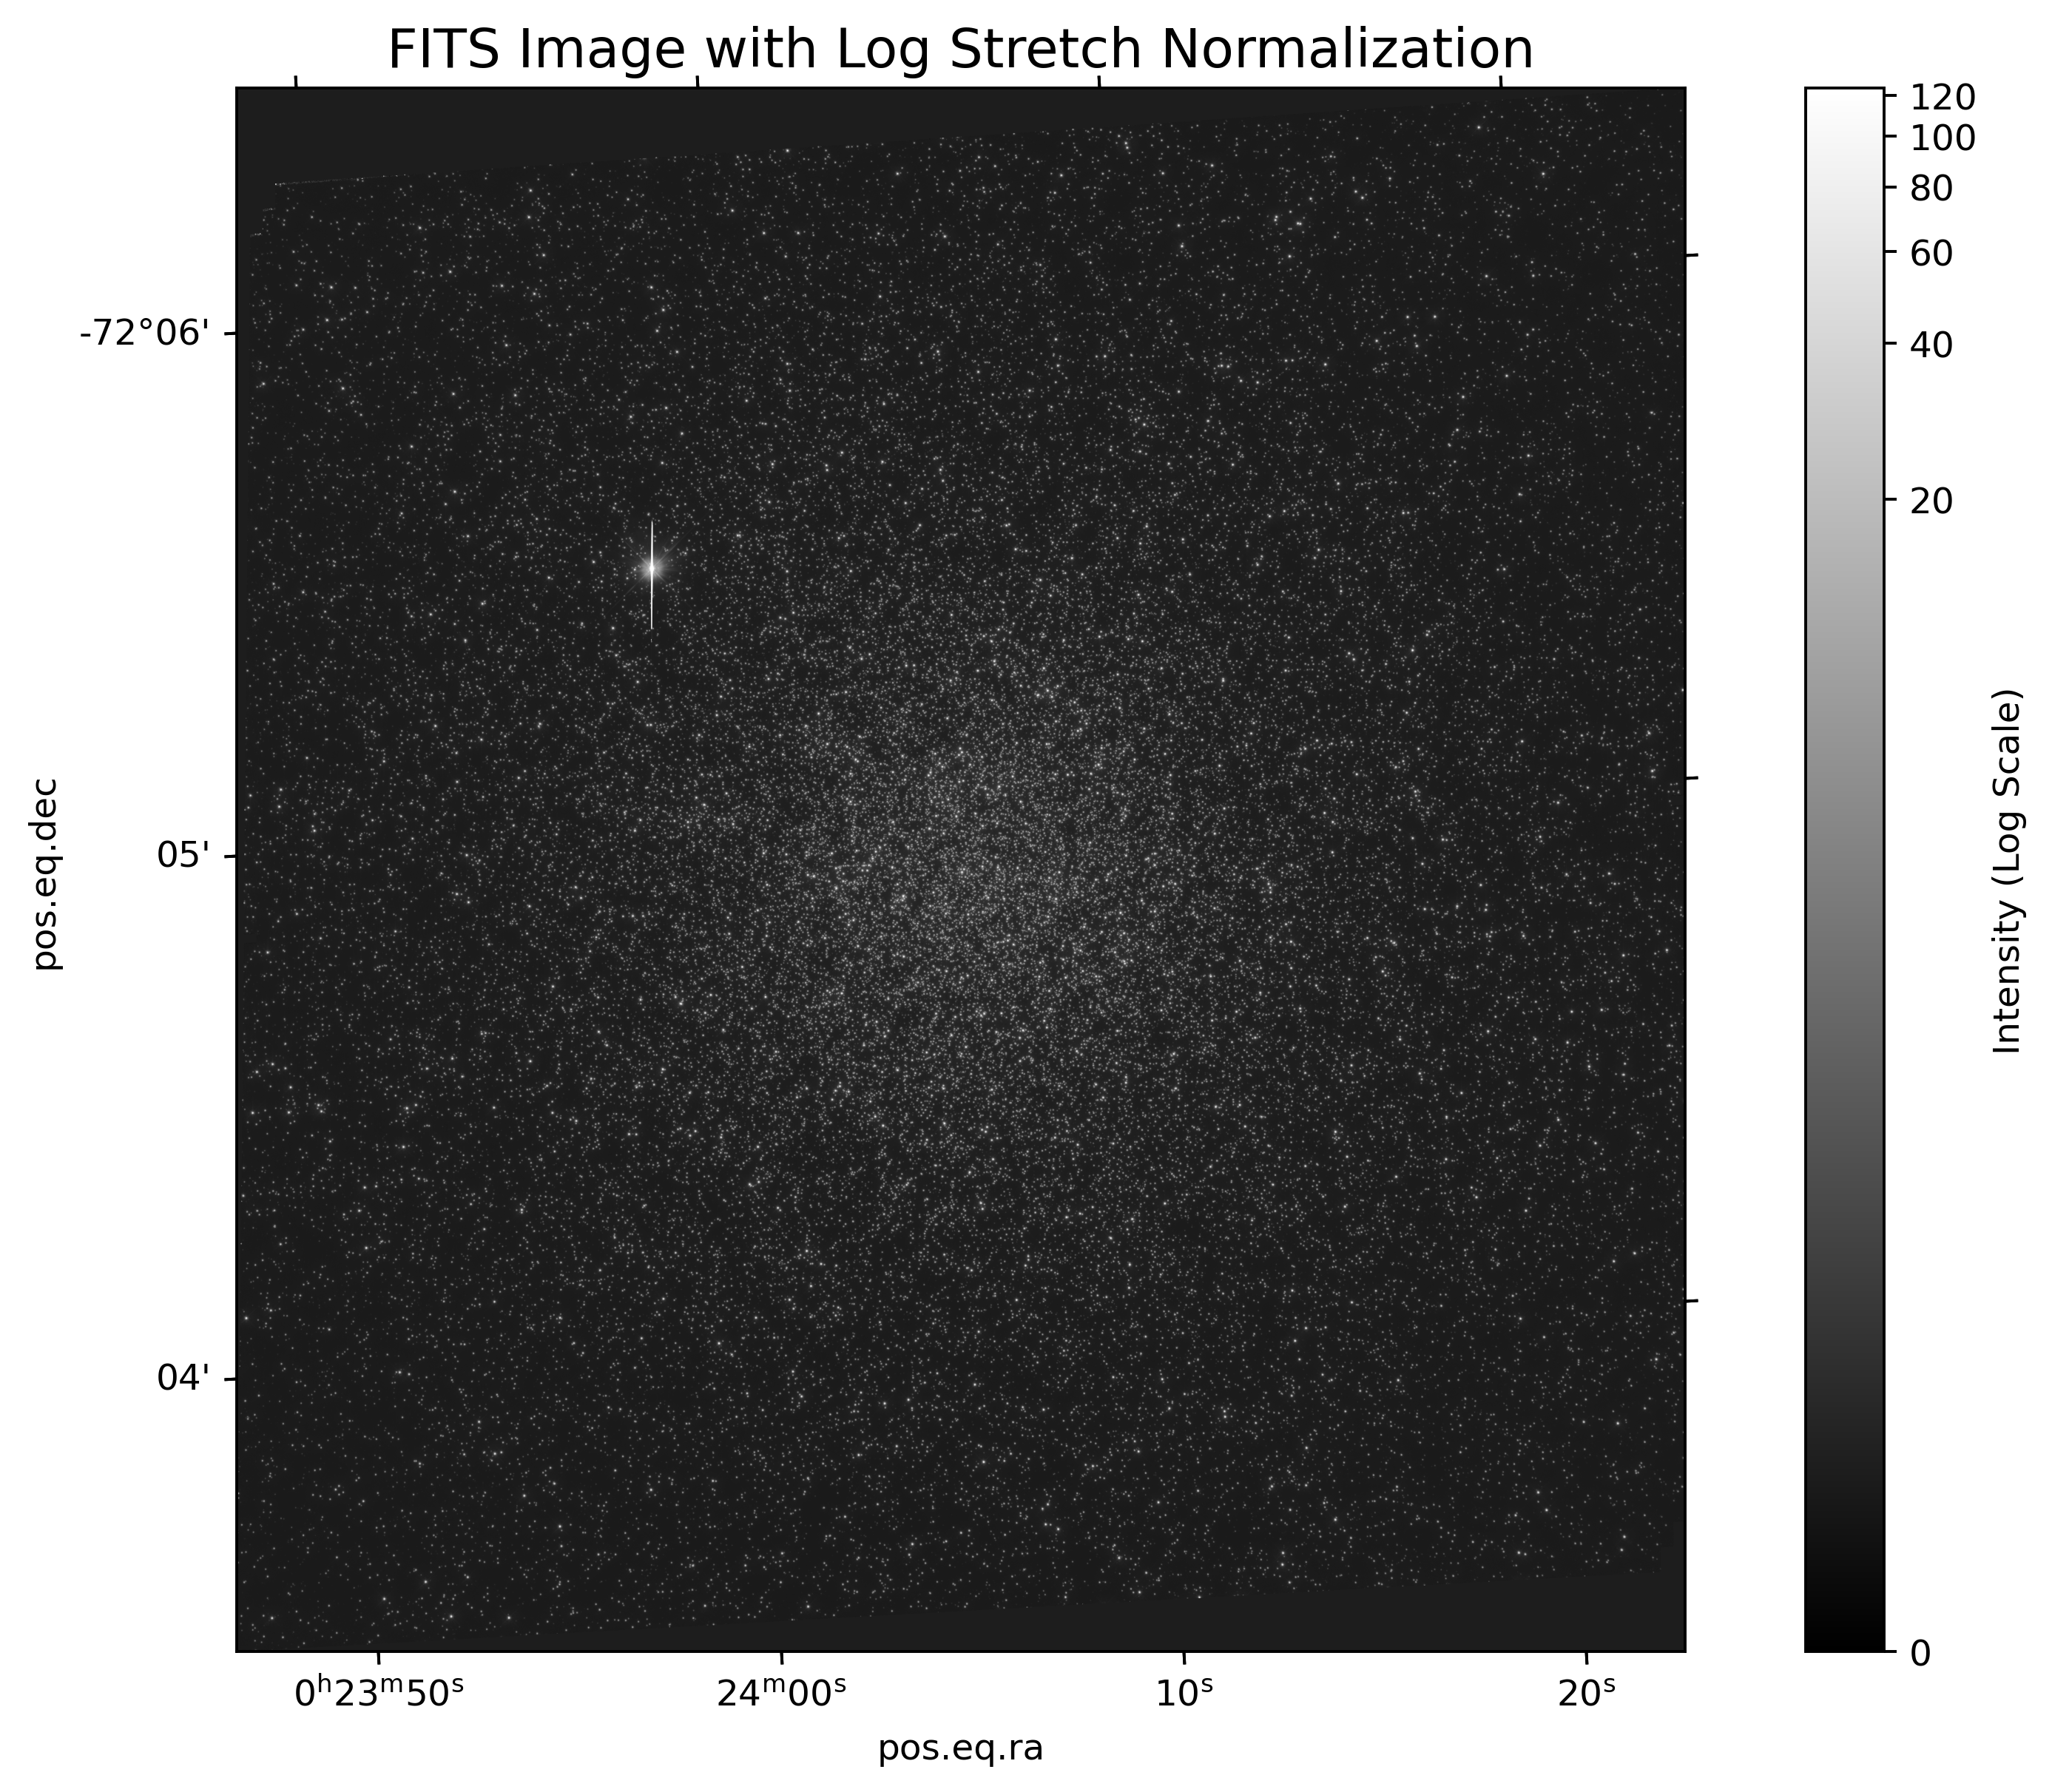

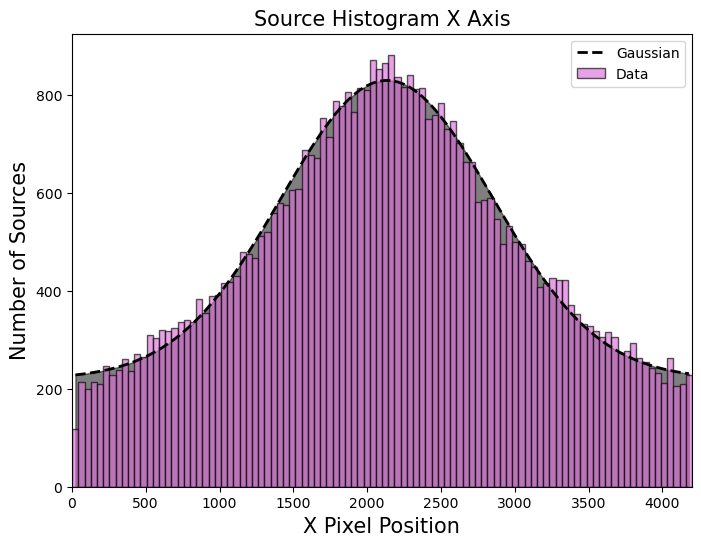

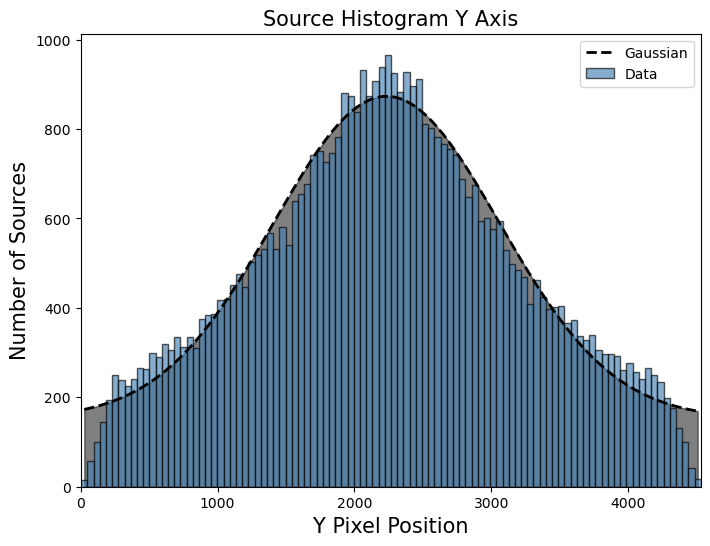

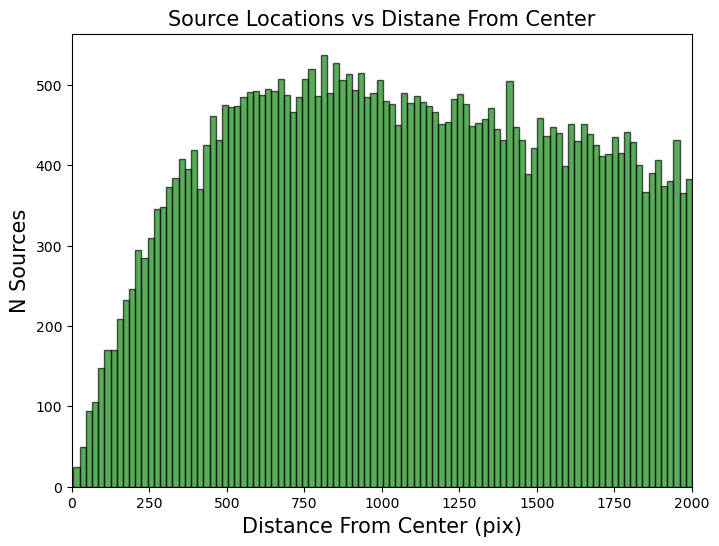

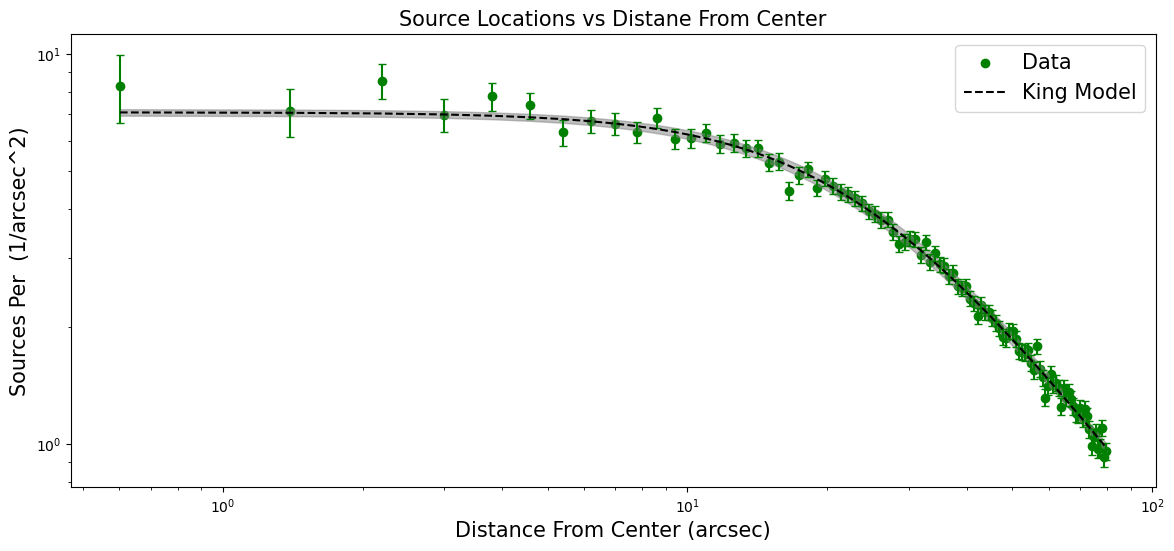

In [3]:
# lets go
snr_threshold = 5
data, nanmean, wcs, header = read_fits_data(data_file)
make_sky_image(data, wcs)
x_centroids, y_centroids = find_sources(data, nanmean, snr_threshold, sigma=5)
x_mean, y_mean = histogram_plots(x_centroids, y_centroids,)
source_location_plot_pix(x_centroids, x_mean, y_centroids, y_mean)
stellar_density_profile(x_centroids, x_mean, y_centroids, y_mean)



(0.0, 2000.0)

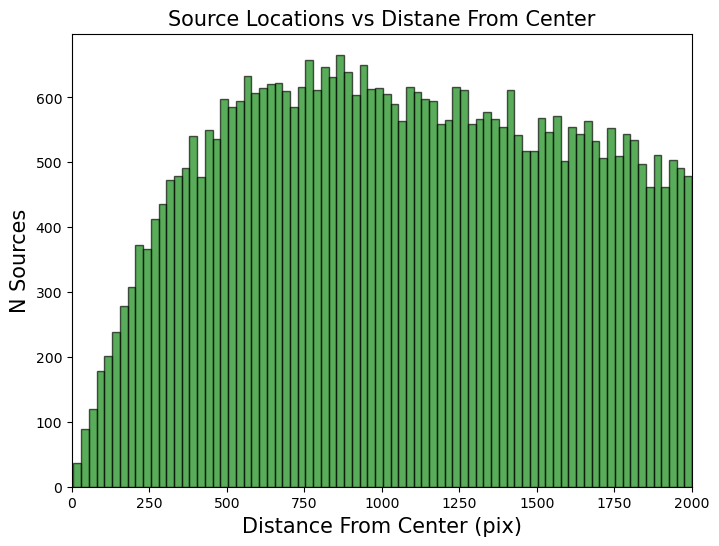

100

(99,)

101

[1 2 3 4] [0 1 2 3]


array([96.80254142,  7.69194282,  5.56135435])

array([4.19869886, 0.48886926, 0.06235528])